In [1]:
## Imports
import sys
import os
import time
import math
import random
import h5py
import re

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
import plot_utils
import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [2]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}


In [3]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    """Plot the signal efficiency vs. background rejection from softmax output
    
    softmaxes          -- 2D np array with shape (num_examples, num_classes)
    labels             -- 1D np array with true ordinal labels e.g. [0,1,2,0,1,...]
    energies           -- 1D np array with true energies for each event
    softmax_index_dict -- Dictionary mapping str class ids e.g. "gamma" to axis=1 idx
                          in the softmax array
    label_0            -- str class id for the signal class e.g. "e"
    label_1            -- str class id for the background class e.g. "gamma"
    min_energy         -- Minimum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    max_energy         -- Maximum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    show               -- Boolean to determine whether to call plt.show()
    save_path          -- Absolute path of the location at which to save the plot        
    """
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map] 
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [4]:
# Input Data
model_folder = "/home/jpeng/GraphNets/dump/cheby_batch_topk20191207_060738/"
dump_folder = os.path.join(model_folder,"valid_validation_cheby_batch_topk_best_600_0.8103323578834534.pth/")
data_folder = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_test/split_h5/"
h5_file = os.path.join(data_folder, "IWCDmPMT_4pi_fulltank_test_graphnet_trainval.h5")
indices_file = os.path.join(data_folder, "IWCDmPMT_4pi_fulltank_test_graphnet_trainval_idxs.npz")

# Output Data
save_fig_loc = os.path.join(dump_folder, "roc_auc.png")
output_loc = os.path.join(dump_folder, "roc_auc_output.npz")


In [5]:
with h5py.File(h5_file, 'r') as h5_data:
    print(list(h5_data.keys()))
    
    indices_data = np.load(indices_file)

    h5_labels = h5_data['labels'].value[indices_data['val_idxs']]
    h5_energies = h5_data['energies'].value[indices_data['val_idxs']]

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions']


In [6]:
softmaxes = np.array([]).reshape(0,3)
regex = re.compile('\d+\.npz')
# label_index = 0

for np_file in sorted(os.listdir(dump_folder)):
    if regex.match(np_file) is not None:
        tmp = np.load(os.path.join(dump_folder, np_file))

    #     l_shape = tmp['label'].shape
    #     print(np.all(h5_labels[label_index:label_index+l_shape[0]] == tmp['label']))
    #     label_index += l_shape[0]

        softmaxes = np.concatenate([softmaxes, tmp['pred_val']])

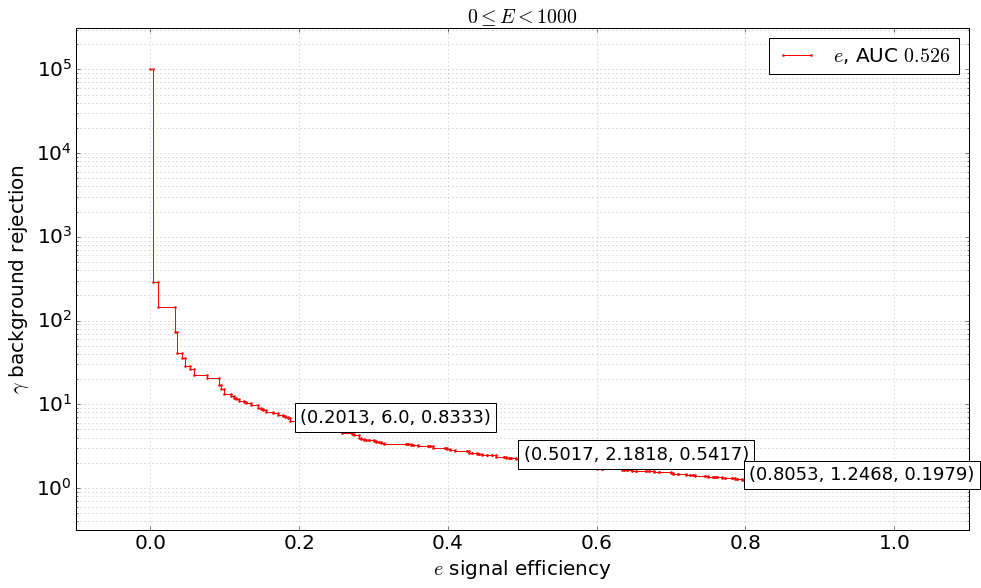

In [7]:
out = plot_new_ROC(softmaxes, h5_labels, h5_energies, softmax_index_dict, "e", "gamma", 
                 min_energy=0, max_energy=1000, show_plot=True, save_path=save_fig_loc)
np.savez(output_loc, fpr=out[0], tpr=out[1], threshold=out[2], roc_auc=out[3])